In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F


In [22]:
# Define your CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layers
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # Adjust input size based on your input image dimensions
        self.fc2 = nn.Linear(128, 26)  # Output layer with 26 nodes (for each class)

        # Dropout Layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # First Convolutional Layer
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Second Convolutional Layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 32 * 14 * 14)  # Adjust the size based on the output size of the last convolutional layer

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [23]:
# Load your dataset from CSV
data = pd.read_csv('sign_mnist_train.csv')

# Separate features (pixels) and labels
X = data.drop(columns=['label']).values
y = data['label'].values

# Reshape features to 28x28 images
X = X.reshape(-1, 1, 28, 28)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [24]:
# Define your model
model = CNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [25]:
# Training
epochs = 10

for epoch in range(epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss for each item in the batch
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy for training data
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average loss and accuracy for training data
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # Set the model to evaluation mode
    correct_test = 0
    total_test = 0
    test_loss = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)

            # Calculate loss for each item in the batch
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy for testing data
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Average loss and accuracy for testing data
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print statistics
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


Epoch [1/10], Train Loss: 1.2289, Train Acc: 73.79%, Test Loss: 0.0858, Test Acc: 97.63%
Epoch [2/10], Train Loss: 0.0812, Train Acc: 97.53%, Test Loss: 0.0208, Test Acc: 99.49%
Epoch [3/10], Train Loss: 0.0624, Train Acc: 98.01%, Test Loss: 0.0047, Test Acc: 99.93%
Epoch [4/10], Train Loss: 0.0374, Train Acc: 98.80%, Test Loss: 0.0142, Test Acc: 99.47%
Epoch [5/10], Train Loss: 0.0366, Train Acc: 98.79%, Test Loss: 0.0190, Test Acc: 99.58%
Epoch [6/10], Train Loss: 0.0395, Train Acc: 98.73%, Test Loss: 0.0011, Test Acc: 100.00%
Epoch [7/10], Train Loss: 0.0304, Train Acc: 99.00%, Test Loss: 0.0015, Test Acc: 99.95%
Epoch [8/10], Train Loss: 0.0243, Train Acc: 99.26%, Test Loss: 0.0077, Test Acc: 99.78%
Epoch [9/10], Train Loss: 0.0293, Train Acc: 99.10%, Test Loss: 0.0039, Test Acc: 99.93%
Epoch [10/10], Train Loss: 0.0328, Train Acc: 99.02%, Test Loss: 0.0024, Test Acc: 99.93%


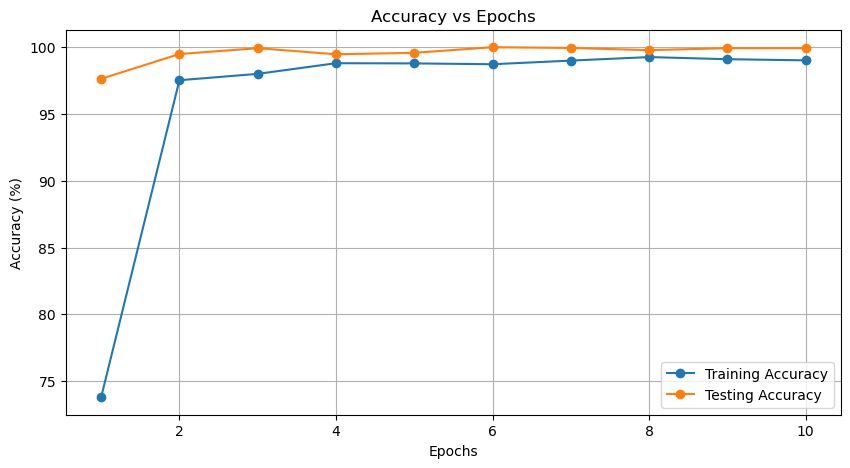

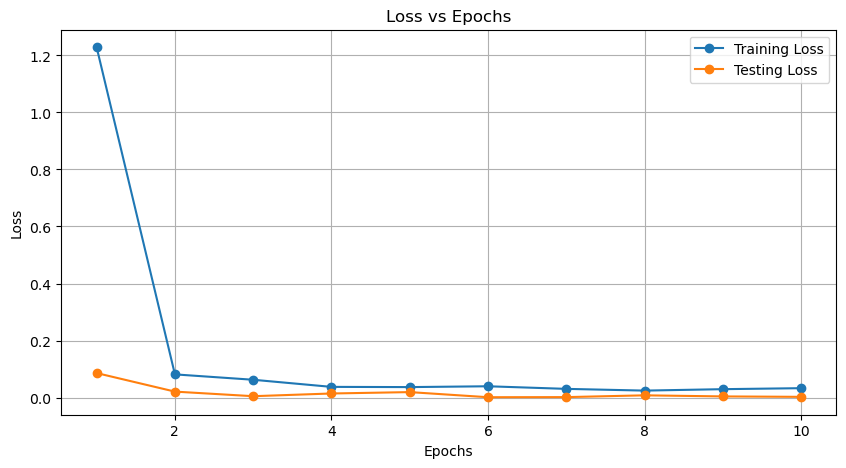

In [26]:
# Plotting accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies,marker='o', label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, marker='o',label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses,marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), test_losses,marker='o',label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
from torchsummary import summary
!pip install torchviz
from torchviz import make_dot

# Define your model
model = CNN()

# Print model summary
summary(model, input_size=(1, 28, 28))  # Assuming input size is (1, 28, 28)

# Visualize model architecture
x = torch.zeros(1, 1, 28, 28)  # Create a dummy input tensor
dot = make_dot(model(x), params=dict(model.named_parameters()))
dot.render("model", format="png")  # Save the visualization as a PNG file


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
         MaxPool2d-2           [-1, 64, 14, 14]               0
            Conv2d-3          [-1, 128, 14, 14]          73,856
         MaxPool2d-4            [-1, 128, 7, 7]               0
            Linear-5                  [-1, 128]         802,944
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 26]           3,354
Total params: 880,794
Trainable params: 880,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.72
Params size (MB): 3.36
Estimated Total Size (MB): 4.08
----------------------------------------------------------------


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH